In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline 
import plotly 
import plotly.graph_objects as go
import plotly.express as pe 
import plotly.offline as po
from plotly.offline import init_notebook_mode
import cufflinks as cf
from plotly.offline import iplot
cf.go_offline()
import warnings
from mlxtend.plotting import plot_confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler,OneHotEncoder,StandardScaler
from sklearn.pipeline import Pipeline,make_pipeline,FeatureUnion
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.cluster import KMeans
from kneed import KneeLocator
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.naive_bayes import GaussianNB  
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay,precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix

In [ ]:
!pip install imblearn

In [ ]:
!pip install kneed

In [2]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.api import add_constant

In [3]:
import pickle

In [4]:
df=pd.read_csv("Thyroid_EDA.csv")

In [5]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,Class
0,41.0,F,f,f,f,f,f,f,f,f,...,f,f,f,f,1.30,2.5,125.0,1.14,109.0,negative
1,23.0,F,f,f,f,f,f,f,f,f,...,f,f,f,f,4.10,2.0,102.0,NaN,NaN,negative
2,46.0,M,f,f,f,f,f,f,f,f,...,f,f,f,f,0.98,NaN,109.0,0.91,120.0,negative
3,70.0,F,t,f,f,f,f,f,f,f,...,f,f,f,f,0.16,1.9,175.0,NaN,NaN,negative
4,70.0,F,f,f,f,f,f,f,f,f,...,f,f,f,f,0.72,1.2,61.0,0.87,70.0,negative


In [6]:
df.isna().sum().sort_values(ascending=False)

T3                           709
T4U                          327
FTI                          325
TSH                          309
TT4                          171
sex                          149
age                            1
psych                          0
hypopituitary                  0
tumor                          0
goitre                         0
lithium                        0
query_hyperthyroid             0
query_hypothyroid              0
I131_treatment                 0
thyroid_surgery                0
pregnant                       0
sick                           0
on_antithyroid_medication      0
query_on_thyroxine             0
on_thyroxine                   0
Class                          0
dtype: int64

# Checking missing values

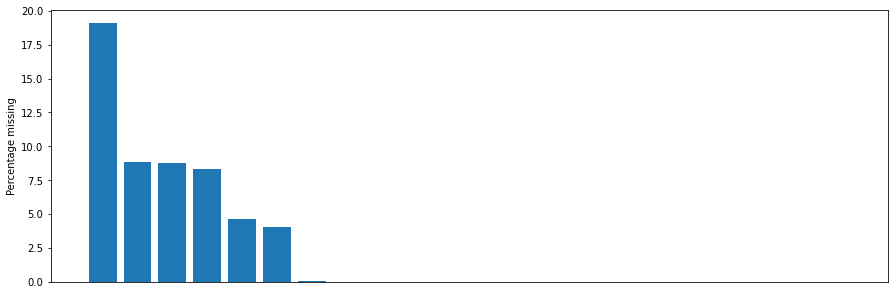

In [7]:
# Plotting Missing values count for each column
fig, ax = plt.subplots(figsize=(15,5))

missing = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)

ax.bar(missing.index, missing.values.T[0])
plt.xticks([])
plt.ylabel("Percentage missing")
plt.show()

In [8]:
missing_values_count= df.isnull().sum()
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
print(f"Percentage of total missing cells in the data {(total_missing/total_cells) * 100}%")

Percentage of total missing cells in the data 2.4386957693344113%


In [9]:
df['Class'].value_counts()

negative                   3420
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

# Visualization of unique values in Target variable

In [10]:
negative = df[df['Class']=='negative'].shape[0]
compensated_hypothyroid= df[df['Class']=='compensated_hypothyroid'].shape[0]
primary_hypothyroid=df[df['Class']=='primary_hypothyroid'].shape[0]
secondary_hypothyroid=df[df['Class']=='secondary_hypothyroid'].shape[0]
pe.bar(df,x=df['Class'].value_counts().index,y=df['Class'].value_counts().values)

In [11]:
Categorical_Features=[cols for cols in df.columns if df[cols].dtypes=='O']
print(Categorical_Features)

['sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych', 'Class']


In [12]:
Categorical_Features.remove('Class')

In [13]:
Categorical_Features

['sex',
 'on_thyroxine',
 'query_on_thyroxine',
 'on_antithyroid_medication',
 'sick',
 'pregnant',
 'thyroid_surgery',
 'I131_treatment',
 'query_hypothyroid',
 'query_hyperthyroid',
 'lithium',
 'goitre',
 'tumor',
 'hypopituitary',
 'psych']

In [14]:
Numerical_Features=[cols for cols in df.columns if df[cols].dtypes!='O']
print(Numerical_Features)

['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']


Columns containing missing values are T3 ,T4U ,FTI ,TSH ,TT4 ,sex ,age from them one is categorical feature and others are numerical feature

lets do the separation of target and independent features 

In [15]:
X=df.drop('Class',axis=1)
X.shape

(3711, 21)

In [16]:
Categorical_Features=[cols for cols in X.columns if X[cols].dtypes=='O']
print(Categorical_Features)

['sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych']


In [17]:
Numerical_Features=[cols for cols in X.columns if X[cols].dtypes!='O']
print(Numerical_Features)

['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']


# Label Encoding and saving encoded label

In [18]:
import joblib

In [19]:
y=df['Class']
y.shape

(3711,)

In [20]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
y_encoded = label_encoder.fit_transform(y)

# Save the label encoder using joblib
import joblib
joblib.dump(label_encoder, 'label_encoder.joblib')

['label_encoder.joblib']

In [22]:
np.unique(y_encoded)

array([0, 1, 2, 3])

Since we are doing classification problem we do not bother for transforming numerical features to noraml distribution 

Create a pipeline for Missing values handling and one hot encoding 

# Experiment 1 : missing value imputation (Numerical) by Median and Handling imbalanced Dataset using Random Oversampling 

In [23]:
numeric_transformer =Pipeline(steps=[
                        ('imputer',SimpleImputer(strategy='median',missing_values=np.nan)),
                        ('robust_scaler',RobustScaler())])

In [24]:
numeric_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('robust_scaler', RobustScaler())])

In [25]:
categorical_transformer = Pipeline(steps=[
                        ('imputer', SimpleImputer(strategy='most_frequent')),
                        ('onehot', OneHotEncoder(drop='first',handle_unknown='ignore'))])

In [26]:
categorical_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot',
                 OneHotEncoder(drop='first', handle_unknown='ignore'))])

In [27]:
np.unique(y)

array(['compensated_hypothyroid', 'negative', 'primary_hypothyroid',
       'secondary_hypothyroid'], dtype=object)

In [28]:
 preprocessor = ColumnTransformer([
                            ('num',numeric_transformer,Numerical_Features),
                            ('cat', categorical_transformer, Categorical_Features)])

In [29]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('robust_scaler',
                                                  RobustScaler())]),
                                 ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['sex', 'on_thyroxine', 'query_on_thyroxine',
                                  'on_antithyroid_medication', 'sick',
                                  'pregnant', 'thyroid_surgery',
                                  'I131_treatment', 'query_hypothyroid',
                                  'query_hyperthyroid', 'lithium', 'goitre',
                                  'tumor', 'hypopituitary', 'psych'])])

In [30]:
X_scaled=preprocessor.fit_transform(X)

# Feature Selection (top 10 )using SelectKbest 

SelectKBest: SelectKBest is a univariate feature selection method that selects the K best features based on their statistical significance. It works by scoring each feature individually and selecting the top K features with the highest scores. This method is simple and efficient for datasets with a small number of features, but it may not work well for datasets with high dimensionality or where features interact with each other.

In [31]:
# Apply feature selection
selector = SelectKBest(f_classif, k=11)
X_selected = selector.fit_transform(X_scaled,y_encoded)

# Get the original feature names for the selected features
mask = selector.get_support()
selected_features = np.array(X.columns)[mask]
print("Selected features:", selected_features)

Selected features: ['sex' 'on_thyroxine' 'query_on_thyroxine' 'on_antithyroid_medication'
 'sick' 'pregnant' 'thyroid_surgery' 'query_hyperthyroid' 'lithium'
 'hypopituitary' 'FTI']


# Feature Selection using Recursive Method 
Recursive Feature Elimination (RFE): RFE is a feature selection method that recursively removes features from the dataset, based on their importance or weight. It works by training a model and then ranking the features based on their importance scores. The least important feature is then removed, and the process is repeated until the desired number of features is obtained. RFE can work well for datasets with complex feature interactions, but it can be computationally expensive and sensitive to the choice of the model.

In [66]:
from sklearn.feature_selection import RFE
# create a linear regression object
model =RandomForestClassifier()
# create the RFE model and select 5 attributes
rfe = RFE(model, n_features_to_select=15, verbose=1)
# fit the RFE model to the data
rfe.fit(X_scaled, y_encoded)
# get the selected feature indices
selected_features = rfe.get_support(indices=True)
# get the original feature names
original_feature_names = list(X.columns[selected_features])
# print the original feature names
print(original_feature_names)

Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
['age', 'sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery', 'query_hyperthyroid', 'goitre', 'tumor', 'hypopituitary', 'psych', 'TT4', 'FTI']


# Feature Selection with CrossValidation Recursive method

Recursive Feature Elimination with Cross-Validation (RFECV): RFECV is an extension of RFE that uses cross-validation to automatically select the optimal number of features. It works by dividing the data into training and validation sets and applying RFE on the training set. The optimal number of features is then determined by selecting the number of features that results in the highest cross-validation score. RFECV can be a good choice when the number of features is high and the optimal number of features is unknown.

In [64]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold


# create a logistic regression model
clf = DecisionTreeClassifier()

# create a recursive feature elimination object
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(5))

# fit the recursive feature elimination object to the data
rfecv.fit(X_scaled, y_encoded)

# print out the selected features
print("Optimal number of features : %d" % rfecv.n_features_)
print("Selected features: ", [f"Feature {i+1}" for i, s in enumerate(rfecv.support_) if s])

# print out the ranking of all features
print("Feature rankings: ", [f"Feature {i+1} ({rank})" for i, rank in enumerate(rfecv.ranking_)])

# print out the cross-validation scores for each number of features
print("CV scores: ", rfecv.grid_scores_)

# get the original feature names
feature_names = [f"Feature {i+1}" for i in range(X.shape[1])]

# create a list of selected feature names
selected_feature_names = [feature_names[i] for i, s in enumerate(rfecv.support_) if s]

# print out the selected feature names
print("Selected feature names: ", selected_feature_names)

Optimal number of features : 15
Selected features:  ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5', 'Feature 6', 'Feature 8', 'Feature 13', 'Feature 14', 'Feature 15', 'Feature 16', 'Feature 17', 'Feature 18', 'Feature 19', 'Feature 20']
Feature rankings:  ['Feature 1 (1)', 'Feature 2 (1)', 'Feature 3 (1)', 'Feature 4 (1)', 'Feature 5 (1)', 'Feature 6 (1)', 'Feature 7 (2)', 'Feature 8 (1)', 'Feature 9 (4)', 'Feature 10 (6)', 'Feature 11 (7)', 'Feature 12 (5)', 'Feature 13 (1)', 'Feature 14 (1)', 'Feature 15 (1)', 'Feature 16 (1)', 'Feature 17 (1)', 'Feature 18 (1)', 'Feature 19 (1)', 'Feature 20 (1)', 'Feature 21 (3)']
CV scores:  [[0.95558546 0.96226415 0.9690027  0.97169811 0.95013477]
 [0.96635262 0.96765499 0.96091644 0.97708895 0.96495957]
 [0.98519515 0.98787062 0.98247978 0.98787062 0.98652291]
 [0.98788694 0.99191375 0.9851752  0.98921833 0.98787062]
 [0.99327052 0.99460916 0.99056604 0.99730458 0.99326146]
 [0.98923284 0.99326146 0.99056604 0.99460916 0.99326

In [65]:
X.columns[[1,2,3,4,5,6,8,13,14,15,16,17,18,19,20]]

Index(['sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'sick', 'pregnant', 'I131_treatment',
       'tumor', 'hypopituitary', 'psych', 'TSH', 'T3', 'TT4', 'T4U', 'FTI'],
      dtype='object')

#Feature selected using RFECV 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'sick', 'pregnant', 'I131_treatment',
       'tumor', 'psych', 'TT4', 'T4U', 'FTI']

# Create Functions for model training and evaluation

In [41]:
def total_cost(y_true, y_pred):
    '''
    This function takes y_true, y_pred, and prints Total cost due to misclassification
    '''
    cm = confusion_matrix(y_true, y_pred)
    cost = 0
    for i in range(cm.shape[0]):
        fp = sum(cm[:,i]) - cm[i,i]
        fn = sum(cm[i,:]) - cm[i,i]
        cost += 10*fp + 500*fn
    return cost

In [42]:
y.shape[0]

3711

In [44]:
y_encoded.shape[0]

3711

In [45]:
def evaluate_clf(true, predicted):
            '''
            This function takes in true values and predicted values
            Returns: Accuracy, F1-Score, Precision, Recall, Roc-auc Score
            '''
            acc = accuracy_score(true, predicted) # Calculate Accuracy
            f1 = f1_score(true, predicted,average='weighted') # Calculate F1-score
            precision = precision_score(true, predicted,average='weighted') # Calculate Precision
            recall = recall_score(true, predicted,average='weighted')  # Calculate Recall
            #roc_auc = roc_auc_score(true, predicted,average='weighted',multi_class='ovr') #Calculate Roc
            return acc, f1 , precision, recall

In [46]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    cost_list=[]
    models_list = []
    accuracy_list = []
    train_recall=[]
    test_recall=[]
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    # Create cost of the model as per data description
    

    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall=evaluate_clf(y_train ,y_train_pred)
        train_recall.append(model_train_recall)
        train_cost = total_cost(y_train, y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall=evaluate_clf(y_test, y_test_pred)
        test_recall.append(model_test_recall)
        test_cost = total_cost(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        #print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
        print(f'- COST: {train_cost}.')

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        #print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        print(f'- COST: {test_cost}.')
        cost_list.append(test_cost)
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, cost_list,train_recall,test_recall,)), columns=['Model Name', 'Cost','Train_Recall','Test_Recall']).sort_values(by=["Cost"])
        
    return report

In [47]:
np.unique(y)

array(['compensated_hypothyroid', 'negative', 'primary_hypothyroid',
       'secondary_hypothyroid'], dtype=object)

#Lets build model and check performance of model using our sleected features

In [48]:
random_over_sample=RandomOverSampler(random_state=42)

In [49]:
 X_resampled,y_resampled=random_over_sample.fit_resample(X_scaled,y_encoded)

In [50]:
X_resampled.shape

(13680, 21)

In [51]:
y_resampled.shape

(13680,)

<AxesSubplot:ylabel='count'>

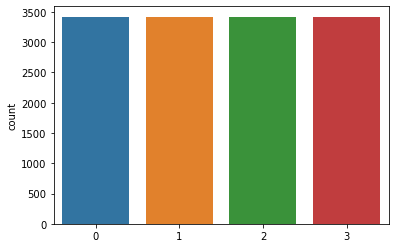

In [52]:
sns.countplot(y_resampled)

In [53]:
# Dictionary which contains models for experiment
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier()
}

In [54]:
report1 = evaluate_models(X_resampled, y_resampled, models)
report1

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9993
- F1 score: 0.9993
- Precision: 0.9993
- Recall: 0.9993
- COST: 1020.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9996
- F1 score: 0.9996
- Precision: 0.9996
- Recall: 0.9996
- COST: 510.


Gradient Boosting
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9993
- F1 score: 0.9993
- Precision: 0.9993
- Recall: 0.9993
- COST: 1020.


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.9938
- F1 score: 0.9938
- Precision: 0.9939
- Rec

,Model Name,Cost,Train_Recall,Test_Recall
1,Decision Tree,510,1.000000,0.999635
0,Random Forest,1020,1.000000,0.999269
2,Gradient Boosting,1020,1.000000,0.999269
4,XGBClassifier,1020,1.000000,0.999269
5,CatBoosting Classifier,1020,1.000000,0.999269
3,K-Neighbors Classifier,9180,0.993787,0.993421
6,AdaBoost Classifier,422790,0.692708,0.697003


# Lets do CrossValidation 

In [55]:
from sklearn.metrics import make_scorer, recall_score

In [56]:
from sklearn.model_selection import KFold,cross_val_score,StratifiedKFold

In [57]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv

StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [58]:
# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [59]:
# Use cross-validation to evaluate model performance
precision_scores = cross_val_score(RandomForestClassifier(), X_train, y_train, cv=cv, scoring="precision_macro")
recall_scores = cross_val_score(RandomForestClassifier(), X_train, y_train, cv=cv, scoring="recall_macro")
f1_scores = cross_val_score(RandomForestClassifier(), X_train, y_train, cv=cv, scoring="f1_macro")

In [60]:
# Output evaluation metrics for a random forest model
print("Precision_random-forest:", precision_scores.mean())
print("Recall_random_forest:", recall_scores.mean())
print("F1-score_random_forest:", f1_scores.mean())

Precision_random-forest: 0.9987477990446478
Recall_random_forest: 0.998952659140549
F1-score_random_forest: 0.9986362975820657


#Crossvalidation for test data  of Random Forest 

In [67]:
# Calculate random forest model evaluation metrics
from sklearn.metrics import precision_score, recall_score, f1_score

# Precision score
precision_rf = precision_score(y_test, RandomForestClassifier().fit(X_train,y_train).predict(X_test), average="macro")
print("Precision_random_forest:", precision_rf)

# Recall score
recall_rf = recall_score(y_test, RandomForestClassifier().fit(X_train,y_train).predict(X_test), average="macro")
print("Recall_random_forest:", recall_rf)

# F1-score
f1_rf = f1_score(y_test, RandomForestClassifier().fit(X_train,y_train).predict(X_test), average="macro")
print("F1-score_forset:", f1_rf)

Precision_random_forest: 0.999029889015916
Recall_random_forest: 0.9992732558139534
F1-score_forset: 0.9992735433066741


# Similrly for Decision Tree 

Cross validation check for traindataset 

In [68]:
# Use cross-validation to evaluate model performance
precision_scores = cross_val_score(DecisionTreeClassifier(), X_train, y_train, cv=cv, scoring="precision_macro")
recall_scores = cross_val_score(DecisionTreeClassifier(), X_train, y_train, cv=cv, scoring="recall_macro")
f1_scores = cross_val_score(DecisionTreeClassifier(), X_train, y_train, cv=cv, scoring="f1_macro")

# Output evaluation metrics for a random forest model
print("Precision_random-forest:", precision_scores.mean())
print("Recall_random_forest:", recall_scores.mean())
print("F1-score_random_forest:", f1_scores.mean())

# Calculate random forest model evaluation metrics
from sklearn.metrics import precision_score, recall_score, f1_score

def random_forest_metrics(X_train, X_test, y_train, y_test):
    """
    Calculate precision, recall, and F1 score for a random forest model.

    Parameters:
    X_train (numpy array): training input data
    X_test (numpy array): testing input data
    y_train (numpy array): training output data
    y_test (numpy array): testing output data

    Returns:
    None
    """
    # Precision score
    precision_rf = precision_score(y_test, DecisionTreeClassifier().fit(X_train,y_train).predict(X_test), average="macro")
    print("Precision_random_forest:", precision_rf)

    # Recall score
    recall_rf = recall_score(y_test, DecisionTreeClassifier().fit(X_train,y_train).predict(X_test), average="macro")
    print("Recall_random_forest:", recall_rf)

    # F1-score
    f1_rf = f1_score(y_test, DecisionTreeClassifier().fit(X_train,y_train).predict(X_test), average="macro")
    print("F1-score_forest:", f1_rf)

random_forest_metrics(X_train, X_test, y_train, y_test)

Precision_random-forest: 0.9993756279631161
Recall_random_forest: 0.9991623027464189
F1-score_random_forest: 0.9993724746218644
Precision_random_forest: 0.9995144734063415
Recall_random_forest: 0.9992732558139534
F1-score_forest: 0.9992702468178922


#After cross validation  Decison Tree is giving 99.9 % for Train Dataset and 99.7% for Test Dataset 

# Experiment No 2 :Handling imbalanced dataset using SMOTE 

In [69]:
X_scaled

array([[-0.41935484, -0.05221932,  0.83333333, ...,  0.        ,
         0.        ,  0.        ],
       [-1.        ,  1.40992167,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.25806452, -0.21932115,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.64516129,  1.93211488, -0.33333333, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.58064516, -0.36553525,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.32258065, -0.20887728,  0.33333333, ...,  0.        ,
         0.        ,  0.        ]])

In [70]:
from imblearn.over_sampling import SMOTE

In [71]:
smt=SMOTE(random_state=42,k_neighbors=1)
X_res_smote,y_res_smote=smt.fit_resample(X_scaled,y_encoded)

In [72]:
report2=evaluate_models(X_res_smote,y_res_smote,models)
report2

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9989
- F1 score: 0.9989
- Precision: 0.9989
- Recall: 0.9989
- COST: 1530.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9971
- F1 score: 0.9971
- Precision: 0.9971
- Recall: 0.9971
- COST: 4080.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9998
- F1 score: 0.9998
- Precision: 0.9998
- Recall: 0.9998
- COST: 1020.
----------------------------------
Model performance for Test set
- Accuracy: 0.9967
- F1 score: 0.9967
- Precision: 0.9967
- Recall: 0.9967
- COST: 4590.


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.9926
- F1 score: 0.9926
- Precision: 0.9927
-

,Model Name,Cost,Train_Recall,Test_Recall
0,Random Forest,1530,1.000000,0.998904
4,XGBClassifier,2040,1.000000,0.998538
5,CatBoosting Classifier,2040,1.000000,0.998538
1,Decision Tree,4080,1.000000,0.997076
2,Gradient Boosting,4590,0.999817,0.996711
3,K-Neighbors Classifier,10710,0.992599,0.992325
6,AdaBoost Classifier,347820,0.752741,0.750731


In [73]:
from sklearn.model_selection import KFold,cross_val_score
k_f = KFold(n_splits=10,shuffle=True)
k_f

KFold(n_splits=10, random_state=None, shuffle=True)

In [74]:
X_train,X_test,y_train,y_test=train_test_split(X_res_smote,y_res_smote,test_size=0.3,random_state=42)

In [75]:
print("Mean of cross validation score for Random Forest model==>",cross_val_score(RandomForestClassifier(),X_train,y_train,cv=k_f).mean())
print("Mean of cross validation score for Decision Tree  model==>",cross_val_score(DecisionTreeClassifier(),X_train,y_train,cv=k_f).mean())

Mean of cross validation score for Random Forest model==> 0.9974931446783725
Mean of cross validation score for Decision Tree  model==> 0.9971801013518673


# Experiment No3 :PCA 

In [76]:
X=df.drop('Class',axis=1)
y=df['Class']

In [77]:
y=LabelEncoder().fit_transform(y)

In [78]:
numeric_transformer =Pipeline(steps=[
                        ('imputer',SimpleImputer(strategy='constant',missing_values=np.nan,fill_value=0)),
                        ('robust_scaler',RobustScaler())])

In [79]:
categorical_transformer = Pipeline(steps=[
                        ('imputer', SimpleImputer(strategy='most_frequent')),
                        ('onehot', OneHotEncoder(drop='first',handle_unknown='ignore'))])

In [80]:
 pca_preprocessor = ColumnTransformer([
                            ('num',numeric_transformer,Numerical_Features),
                            ('cat', categorical_transformer, Categorical_Features)])

In [81]:
X_pca=pca_preprocessor.fit_transform(X)

In [82]:
#Applying PCA
from sklearn.decomposition import PCA
var_ratio={}
for n in range(2,21):
    pc=PCA(n_components=n)
    df_pca=pc.fit(X_pca)
    var_ratio[n]=sum(df_pca.explained_variance_ratio_)

Variace plot 

<AxesSubplot:>

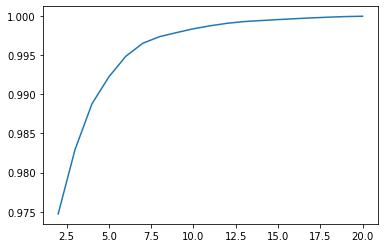

In [83]:
# plotting variance ratio
pd.Series(var_ratio).plot()

Kneed algorithm to find the elbow point

<Figure size 360x360 with 0 Axes>

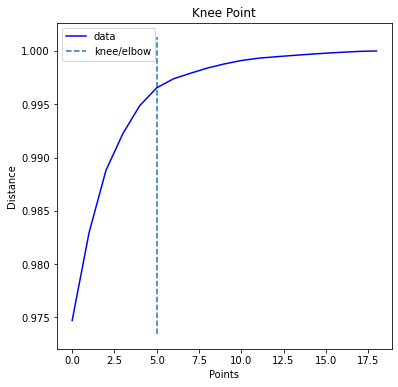

Knee Locator k = 7


In [84]:
from kneed import KneeLocator

i = np.arange(len(var_ratio))
variance_ratio= list(var_ratio.values())
components=  list(var_ratio.keys())
knee = KneeLocator(i, variance_ratio, S=1, curve='concave', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()
k= components[knee.knee]
print('Knee Locator k =', k)

In [85]:
# Reducing the dimensions of the data 
pca_final=PCA(n_components=7,random_state=42).fit(X_resampled)

reduced=pca_final.fit_transform(X_pca)

In [86]:
# Resampling the minority class. The strategy can be changed as required.
smt =RandomOverSampler(random_state=42)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(reduced, y)

In [87]:
X_train,X_test,y_train,y_test=train_test_split(X_res,y_res,random_state=42,test_size=0.2)

In [88]:
report3 = evaluate_models(X_res, y_res, models)
report3

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9956
- F1 score: 0.9956
- Precision: 0.9957
- Recall: 0.9956
- COST: 6120.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9963
- F1 score: 0.9963
- Precision: 0.9964
- Recall: 0.9963
- COST: 5100.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9989
- F1 score: 0.9989
- Precision: 0.9989
- Recall: 0.9989
- COST: 6120.
----------------------------------
Model performance for Test set
- Accuracy: 0.9960
- F1 score: 0.9960
- Precision: 0.9960
- Recall: 0.9960
- COST: 5610.


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.9933
- F1 score: 0.9933
- Precision: 0.9935
-

,Model Name,Cost,Train_Recall,Test_Recall
1,Decision Tree,5100,1.000000,0.996345
2,Gradient Boosting,5610,0.998904,0.995980
0,Random Forest,6120,1.000000,0.995614
4,XGBClassifier,6630,1.000000,0.995249
5,CatBoosting Classifier,7650,0.999909,0.994518
3,K-Neighbors Classifier,12240,0.993330,0.991228
6,AdaBoost Classifier,568140,0.587171,0.592836


# lets do feature importance for our Decision Tree model 

In [101]:
model=DecisionTreeClassifier()

In [102]:
X_train,X_test,y_train,y_test=train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=42)

In [103]:
model.fit(X_train,y_train)

DecisionTreeClassifier()

In [104]:
importances = model.feature_importances_

In [105]:
importances

array([1.51517383e-02, 3.27814285e-01, 6.96784270e-03, 3.51186554e-01,
       2.39068771e-04, 2.86829964e-01, 0.00000000e+00, 1.03491748e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.46137176e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [106]:
# Create a DataFrame with feature names and importances
features_df = pd.DataFrame({'feature_name': X.columns, 'importance': importances})
features_df

,feature_name,importance
0,age,0.015152
1,sex,0.327814
2,on_thyroxine,0.006968
3,query_on_thyroxine,0.351187
4,on_antithyroid_medication,0.000239
5,sick,0.286830
6,pregnant,0.000000
7,thyroid_surgery,0.010349
8,I131_treatment,0.000000
9,query_hypothyroid,0.000000


In [107]:
# Sort the features by importance
features_df = features_df.sort_values('importance', ascending=False)

In [108]:
features_df

,feature_name,importance
3,query_on_thyroxine,0.351187
1,sex,0.327814
5,sick,0.286830
0,age,0.015152
7,thyroid_surgery,0.010349
2,on_thyroxine,0.006968
12,goitre,0.001461
4,on_antithyroid_medication,0.000239
14,hypopituitary,0.000000
19,T4U,0.000000


In [109]:
# Get the top n features
n = 10
top_n_features = list(features_df['feature_name'][:n])

# Print the top n features
print(f'Top {n} features:')
print(top_n_features)

Top 10 features:
['query_on_thyroxine', 'sex', 'sick', 'age', 'thyroid_surgery', 'on_thyroxine', 'goitre', 'on_antithyroid_medication', 'hypopituitary', 'T4U']


# lets try to build model on selected features from RFECV and check performance of train and test dataset 

selected features are Index(['sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'sick', 'pregnant', 'I131_treatment',
       'tumor', 'hypopituitary', 'psych', 'TSH', 'T3', 'TT4', 'T4U', 'FTI'],
      dtype='object')

In [110]:
X.columns[[1,2,3,4,5,6,8,13,14,15,16,17,18,19,20]]

Index(['sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'sick', 'pregnant', 'I131_treatment',
       'tumor', 'hypopituitary', 'psych', 'TSH', 'T3', 'TT4', 'T4U', 'FTI'],
      dtype='object')

In [111]:
df1=pd.read_csv("Thyroid_EDA.csv",usecols=['sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'sick', 'pregnant', 'I131_treatment',
       'tumor', 'hypopituitary', 'psych', 'TSH', 'T3', 'TT4', 'T4U', 'FTI','Class'])

In [112]:
df1.shape

(3711, 16)

In [113]:
df1.head()

,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,I131_treatment,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,Class
0,F,f,f,f,f,f,f,f,f,f,1.30,2.5,125.0,1.14,109.0,negative
1,F,f,f,f,f,f,f,f,f,f,4.10,2.0,102.0,NaN,NaN,negative
2,M,f,f,f,f,f,f,f,f,f,0.98,NaN,109.0,0.91,120.0,negative
3,F,t,f,f,f,f,f,f,f,f,0.16,1.9,175.0,NaN,NaN,negative
4,F,f,f,f,f,f,f,f,f,f,0.72,1.2,61.0,0.87,70.0,negative


In [114]:
Num_cols=[cols for cols in df1.columns if df1[cols].dtype!='O']
print(Num_cols)

['TSH', 'T3', 'TT4', 'T4U', 'FTI']


In [115]:
Cat_cols=[cols for cols in df1.columns if df1[cols].dtype=='O']
print(Cat_cols)

['sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'sick', 'pregnant', 'I131_treatment', 'tumor', 'hypopituitary', 'psych', 'Class']


In [119]:
#lets do separation of target variable 
X=df1.drop('Class',axis=1)
print(X.shape)

(3711, 15)


In [120]:
#Lets do transformation pipeline for Numerical and Categorical Columns 
numeric_transformer =Pipeline(steps=[
                        ('imputer',SimpleImputer(strategy='median',missing_values=np.nan)),
                        ('robust_scaler',RobustScaler())])

In [121]:
categorical_transformer = Pipeline(steps=[
                        ('imputer', SimpleImputer(strategy='most_frequent')),
                        ('onehot', OneHotEncoder(drop='first',handle_unknown='ignore'))])

In [122]:
Cat_cols.remove('Class')

In [123]:
 preprocessor_final = ColumnTransformer([
                            ('num',numeric_transformer,Num_cols),
                            ('cat', categorical_transformer, Cat_cols)])

In [124]:
step2=DecisionTreeClassifier()

In [125]:
pipe=Pipeline([('preprocessor1',preprocessor_final),
               ('step2',step2)])
pipe.fit(X,y)

Pipeline(steps=[('preprocessor1',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robust_scaler',
                                                                   RobustScaler())]),
                                                  ['TSH', 'T3', 'TT4', 'T4U',
                                                   'FTI']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['sex', 'on_thyroxine',
                                                   'query_on_thyroxine',
                                                   'on_antithyroid_medication',
                                                   'sick', 'pregnant',
                                                   'I131_treatment', 'tumor',
                                                   'hypopituitary',
                                                   'psych'])])),
                ('step2', DecisionTreeClassifier())])

In [126]:
X_scaled_final=preprocessor_final.fit_transform(X)

In [127]:
from imblearn.over_sampling import SMOTE

In [130]:
le=joblib.load('label_encoder.joblib')
le

LabelEncoder()

In [134]:
y=le.fit_transform(y)
y

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [135]:
smt=SMOTE(random_state=42,k_neighbors=1)
X_res1,y_res1=smt.fit_resample(X_scaled_final,y,)

In [136]:
report4=evaluate_models(X_res1,y_res1,models)
report4

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9978
- F1 score: 0.9978
- Precision: 0.9978
- Recall: 0.9978
- COST: 3060.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9974
- F1 score: 0.9974
- Precision: 0.9975
- Recall: 0.9974
- COST: 3570.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9994
- F1 score: 0.9994
- Precision: 0.9994
- Recall: 0.9994
- COST: 3570.
----------------------------------
Model performance for Test set
- Accuracy: 0.9938
- F1 score: 0.9938
- Precision: 0.9938
- Recall: 0.9938
- COST: 8670.


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.9938
- F1 score: 0.9938
- Precision: 0.9939
-

,Model Name,Cost,Train_Recall,Test_Recall
0,Random Forest,3060,1.000000,0.997807
4,XGBClassifier,3060,1.000000,0.997807
1,Decision Tree,3570,1.000000,0.997442
5,CatBoosting Classifier,3570,0.999817,0.997442
2,Gradient Boosting,8670,0.999360,0.993787
3,K-Neighbors Classifier,11730,0.993787,0.991594
6,AdaBoost Classifier,38760,0.973501,0.972222


lets try with randomoversampling technique to handle imbalanced daatset with selected features 

In [137]:
random=RandomOverSampler()

In [138]:
X_res2,y_res2=random.fit_resample(X_scaled_final,y)

In [139]:
report5=evaluate_models(X_res2,y_res2,models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9989
- F1 score: 0.9989
- Precision: 0.9989
- Recall: 0.9989
- COST: 1530.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9993
- F1 score: 0.9993
- Precision: 0.9993
- Recall: 0.9993
- COST: 1020.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9998
- F1 score: 0.9998
- Precision: 0.9998
- Recall: 0.9998
- COST: 1020.
----------------------------------
Model performance for Test set
- Accuracy: 0.9985
- F1 score: 0.9985
- Precision: 0.9985
- Recall: 0.9985
- COST: 2040.


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.9947
- F1 score: 0.9947
- Precision: 0.9948
-

In [140]:
report5

,Model Name,Cost,Train_Recall,Test_Recall
1,Decision Tree,1020,1.000000,0.999269
0,Random Forest,1530,1.000000,0.998904
2,Gradient Boosting,2040,0.999817,0.998538
4,XGBClassifier,2040,1.000000,0.998538
5,CatBoosting Classifier,2040,1.000000,0.998538
3,K-Neighbors Classifier,9690,0.994700,0.993056
6,AdaBoost Classifier,182580,0.859740,0.869152


In [141]:
import joblib

In [142]:
with open('df.pkl','wb')as file:
    pickle.dump(df1,file)

In [143]:
joblib.dump(pipe,'final_pipe_object.joblib')

['final_pipe_object.joblib']

#Prediction on new dataset with created model 

In [144]:
df = pd.read_pickle('df.pkl')

In [145]:
df.head()

,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,I131_treatment,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,Class
0,F,f,f,f,f,f,f,f,f,f,1.30,2.5,125.0,1.14,109.0,negative
1,F,f,f,f,f,f,f,f,f,f,4.10,2.0,102.0,NaN,NaN,negative
2,M,f,f,f,f,f,f,f,f,f,0.98,NaN,109.0,0.91,120.0,negative
3,F,t,f,f,f,f,f,f,f,f,0.16,1.9,175.0,NaN,NaN,negative
4,F,f,f,f,f,f,f,f,f,f,0.72,1.2,61.0,0.87,70.0,negative


In [146]:
model=joblib.load('final_pipe_object.joblib')

In [147]:
label_predictor=joblib.load('label_encoder.joblib')

In [148]:
model

Pipeline(steps=[('preprocessor1',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robust_scaler',
                                                                   RobustScaler())]),
                                                  ['TSH', 'T3', 'TT4', 'T4U',
                                                   'FTI']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['sex', 'on_thyroxine',
                                                   'query_on_thyroxine',
                                                   'on_antithyroid_medication',
                                                   'sick', 'pregnant',
                                                   'I131_treatment', 'tumor',
                                                   'hypopituitary',
                                                   'psych'])])),
                ('step2', DecisionTreeClassifier())])

In [176]:
df1.sample(2)

,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,I131_treatment,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,Class
3404,F,f,f,f,f,f,f,f,f,f,7.50,1.6,82.0,1.08,77.0,compensated_hypothyroid
1039,M,f,f,f,f,f,t,f,f,f,0.01,2.4,108.0,0.70,154.0,negative


In [177]:
data={
   'sex':'M',
    'on_thyroxine':'f',
    'query_on_thyroxine':'f',
    'on_antithyroid_medication':'f',
    'sick':'f',
    'pregnant':'f',
    'I131_treatment':'f',
    'tumor':'f',
    'hypopituitary':'f',
    'psych':'f',
    'TSH':7.50,
    'T3':1.6,
    'TT4':82.0,
    'T4U':1.08,
    'FTI':65.0
}

In [178]:
df_test=pd.DataFrame(data,index=[0])
df_test

,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,I131_treatment,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI
0,M,f,f,f,f,f,f,f,f,f,7.5,1.6,82.0,1.08,77.0


In [172]:
label_predictor.inverse_transform([1])

array(['negative'], dtype=object)

In [181]:
model.predict(df_test)[0]

'compensated_hypothyroid'

In [189]:
data2={
   'sex':'F',
    'on_thyroxine':'f',
    'query_on_thyroxine':'f',
    'on_antithyroid_medication':'f',
    'sick':'f',
    'pregnant':'t',
    'I131_treatment':'f',
    'tumor':'f',
    'hypopituitary':'f',
    'psych':'f',
    'TSH':7.50,
    'T3':1.9,
    'TT4':190.0,
    'T4U':1.08,
    'FTI':65.0
}

In [190]:
df_test=pd.DataFrame(data2,index=[0])
df_test

,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,I131_treatment,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI
0,F,f,f,f,f,t,f,f,f,f,7.5,1.9,190.0,1.08,65.0


In [191]:
model.predict(df_test)[0]

'negative'